# Web Scraping & Data Analysis with Selenium and Python



### Vinay Babu

Github: https://github.com/min2bro/WebScrapingwithSelenium

Twitter: @min2bro

# Data Science ToolBox

<img src="./img/DataScienceToolbox.png">

# IPython Notebook

* Write, Edit, Replay python scripts
* Interactive Data Visualization and report Presentation
* Notebook can be saved and shared
* Run Selenium Python Scripts

## Pandas

* Python Data Analysis Library

## Matplotlib

* plotting library for the Python



<img src="./img/Steps2follow.png">

# Analysis of the Filmfare Awards for Best Picture from 1955-2015

<img src="./img/wordcloud2.jpg">
<img src="./img/wordcloud3.png">

### Web Scraping: Extracting Data from the Web

#### Some Import

In [31]:
%matplotlib inline 
from selenium import webdriver
import os,time,json
import pandas as pd
from collections import defaultdict,Counter
import matplotlib.pyplot as plt

#### Initial Setup and Launch the browser to open the URL

In [32]:
url = "http://www.imdb.com/list/ls061683439/"
with open('./img/filmfare.json',encoding="utf-8") as f:
    datatbl = json.load(f)
driver = webdriver.Chrome(datatbl['data']['chromedriver'])
driver.get(url)

### Getting Data

#### Function to extract the data from Web using Selenium

In [33]:
def ExtractText(Xpath):
    textlist=[]
    if(Xpath=="Movies_Runtime_Xpath"):
        [textlist.append(item.text[-10:-7]) for item in driver.find_elements_by_xpath(datatbl['data'][Xpath])]
    else:    
        [textlist.append(item.text) for item in driver.find_elements_by_xpath(datatbl['data'][Xpath])]
    return textlist

#### Let's extract all the required data like Ratings,Votes,Genre, Year of Release for the Best Movies

In [34]:
#Extracting Data from Web
Movies_Votes,Movies_Name,Movies_Ratings,Movies_RunTime=[[] for i in range(4)]
datarepo = [[]]*4
Xpath_list = ['Movies_Name_Xpath','Movies_Rate_Xpath','Movies_Runtime_Xpath','Movies_Votes_Xpath']

for i in range(4):
    if(i==3):
        driver.find_element_by_xpath(datatbl['data']['listview']).click()
    datarepo[i] = ExtractText(Xpath_list[i])
    
driver.quit()

### How does data looks now?
#### Is this Data is in the correct format to perform data manipulation?

#### The individual movie related data is stored in a Python List, it's hard to corelated the data attributes with the respective Movies 

In [35]:
# Movie Name List & Ratings
print(datarepo[0][:5])
print(datarepo[3][:5])

['Bajirao Mastani', 'Queen', 'Bhaag Milkha Bhaag', 'Barfi!', 'Zindagi Na Milegi Dobara']
['17,283', '39,478', '39,688', '52,270', '41,706']


### Store Data in a  Python Dictionary

#### The data is stored in a python dictionary which is more structured way to store the data here and all the movie attributes are now linked with the respective movie

In [36]:
# Result in a Python Dictionary
Years=range(2015,1954,-1)
result = defaultdict(dict)
for i in range(0,len(datarepo[0])):
    result[i]['Movie Name']= datarepo[0][i]
    result[i]['Year']= Years[i]
    result[i]['Rating']= datarepo[1][i]
    result[i]['Votes']= datarepo[3][i]
    result[i]['RunTime']= datarepo[2][i]


### Let's see now how the data in dictionary looks like?

In [37]:
result

defaultdict(dict,
            {0: {'Movie Name': 'Bajirao Mastani',
              'Rating': '7.2',
              'RunTime': '158',
              'Votes': '17,283',
              'Year': 2015},
             1: {'Movie Name': 'Queen',
              'Rating': '8.4',
              'RunTime': '146',
              'Votes': '39,478',
              'Year': 2014},
             2: {'Movie Name': 'Bhaag Milkha Bhaag',
              'Rating': '8.3',
              'RunTime': '186',
              'Votes': '39,688',
              'Year': 2013},
             3: {'Movie Name': 'Barfi!',
              'Rating': '8.2',
              'RunTime': '151',
              'Votes': '52,270',
              'Year': 2012},
             4: {'Movie Name': 'Zindagi Na Milegi Dobara',
              'Rating': '8.1',
              'RunTime': '155',
              'Votes': '41,706',
              'Year': 2011},
             5: {'Movie Name': 'Dabangg',
              'Rating': '6.3',
              'RunTime': '126',
         

In [38]:
print(json.dumps(result[58], indent=2))

{
  "Movie Name": "Jagriti",
  "Rating": "7.8",
  "Year": 1957,
  "RunTime": "sti",
  "Votes": "82"
}


#### Oh! Something is wrong with the data, It's not in right shape to perform analysis on this data set

### Let's clean the data

* Replace the comma(,) in Vote Value and change the data type to int
* Change the Data type for Rating and RunTime

In [39]:
for key,values in result.items():
    values['Votes'] = int(values['Votes'].replace(",",""))
    values['Rating']= float(values['Rating'])
    try:
        values['RunTime'] = int(values['RunTime'])
    except ValueError:
        values['RunTime'] = 154
        
    

#### Now let's look at the data and see how it looks like

In [40]:
result[58]

{'Movie Name': 'Jagriti',
 'Rating': 7.8,
 'RunTime': 154,
 'Votes': 82,
 'Year': 1957}

### Data in Pandas Dataframe

#### Data is consumed in a Pandas Dataframe, Which is more convenient way to perform data analysis,manipulation or aggregation

In [55]:
# create dataframe
df = pd.DataFrame.from_dict(result,orient='index')
df = df[['Year', 'Movie Name', 'Rating', 'Votes','RunTime']]
df

,Year,Movie Name,Rating,Votes,RunTime
0,2015,Bajirao Mastani,7.2,17283,158
1,2014,Queen,8.4,39478,146
2,2013,Bhaag Milkha Bhaag,8.3,39688,186
3,2012,Barfi!,8.2,52270,151
4,2011,Zindagi Na Milegi Dobara,8.1,41706,155
5,2010,Dabangg,6.3,19768,126
6,2009,3 Idiots,8.4,200956,170
7,2008,Jodhaa Akbar,7.6,17902,213
8,2007,Like Stars on Earth,8.5,82648,165
9,2006,Rang De Basanti,8.4,68550,157


### Let's use some of the Pandas functions now and start the Analysis

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61 entries, 0 to 60
Data columns (total 6 columns):
Year           61 non-null int64
Movie Name     61 non-null object
Rating         61 non-null float64
Votes          61 non-null int64
RunTime        61 non-null int64
Ratingbyten    61 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 3.3+ KB


### Movies with Highest Ratings

#### The top five movies with Maximum Rating since 1955

In [48]:
#Highest Rating Movies
df.sort_values('Rating',ascending=[False]).head(5)

,Year,Movie Name,Rating,Votes,RunTime
42,1973,Anand,8.9,10718,122
47,1968,Guide,8.6,3950,183
8,2007,Like Stars on Earth,8.5,82648,165
60,1955,Do Bigha Zamin,8.4,1104,131
53,1962,Mughal-E-Azam,8.4,3868,197


### Movies with Maximum Run time

#### Top 10 movies with maximum Run time

In [49]:
#Movies with maximum Run Time
df.sort_values(['RunTime'],ascending=[False]).head(10)

,Year,Movie Name,Rating,Votes,RunTime
14,2001,Lagaan: Once Upon a Time in India,8.2,68811,224
7,2008,Jodhaa Akbar,7.6,17902,213
21,1994,Hum Aapke Hain Koun...!,7.7,10945,206
53,1962,Mughal-E-Azam,8.4,3868,197
26,1989,Maine Pyar Kiya,7.5,5799,192
11,2004,Veer-Zaara,7.9,33468,192
20,1995,Dilwale Dulhania Le Jayenge,8.3,42056,189
16,1999,Straight from the Heart,7.6,9793,188
24,1991,Lamhe,7.4,1928,187
2,2013,Bhaag Milkha Bhaag,8.3,39688,186


## Best Movie Run time

#### Let's plot a graph to see the movie run time trend from 1955 thru 2015

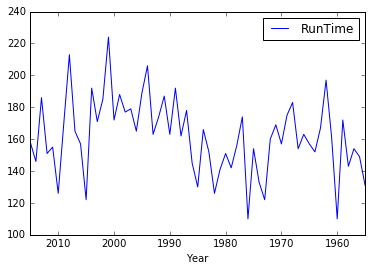

In [75]:
df.plot(x=df.Year,y=['RunTime']);

#### Mean of the Movie Run Time

In [48]:
df['RunTime'].mean()

154.2622950819672

### Best Movie Ratings

#### Perform some analysis on the ratings of all the Best won movies

* No. of Movies Greater than IMDB 7 ratings

In [76]:
df[(df['Rating']>=7)]['Rating'].count()

56

#### Movie Ratings Visualization using Bar Graph

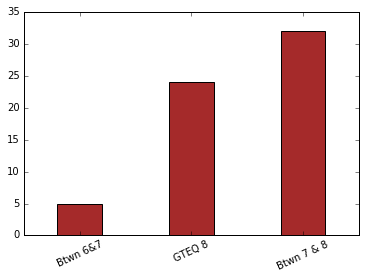

In [77]:
Rating_Histdic = defaultdict(dict)

Rating_Histdic['Btwn 6&7'] = df[(df['Rating']>=6)&(df['Rating']<7)]['Rating'].count()
Rating_Histdic['GTEQ 8'] = df[(df['Rating']>=8)]['Rating'].count()
Rating_Histdic['Btwn 7 & 8'] = df[(df['Rating']>=7)&(df['Rating']<8)]['Rating'].count()


plt.bar(range(len(Rating_Histdic)), Rating_Histdic.values(), align='center',color='brown',width=0.4)
plt.xticks(range(len(Rating_Histdic)), Rating_Histdic.keys(), rotation=25);

#### Percentage distribution of the Ratings in a Pie-Chart

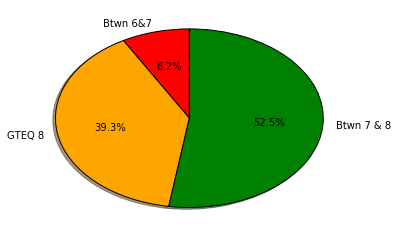

In [78]:
Rating_Hist = []
import numpy as np
    
Rating_Hist.append(Rating_Histdic['Btwn 6&7'])
Rating_Hist.append(Rating_Histdic['GTEQ 8'])
Rating_Hist.append(Rating_Histdic['Btwn 7 & 8'])

labels = ['Btwn 6&7', 'GTEQ 8', 'Btwn 7 & 8']
colors = ['red', 'orange', 'green']

plt.pie(Rating_Hist,labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=90);

### Best Picture by Genre

#### Let's analyze the Genre for the best won movies

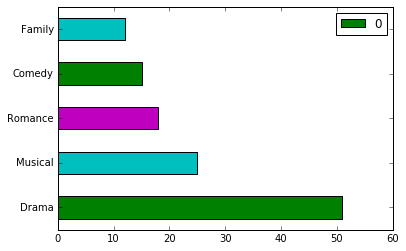

In [54]:
Category=Counter(datatbl['data']['Genre'])
df1 = pd.DataFrame.from_dict(Category,orient='index')
df1 = df1.sort_values([0],ascending=[False]).head(5)
df1.plot(kind='barh',color=['g','c','m']);

# Conclusion : 
  
* Movies with Ratings greater than 7  
* Run time more than 2hrs 
* Category Drama & Musical are most likely to be selcted for Best Picture